In [2]:
import numpy as np
import pandas as pd
from scipy import optimize

import matplotlib.pyplot as plt

import multipletau

In [3]:
%pdb

Automatic pdb calling has been turned ON


In [4]:
def func_(x, T, c):
    return (( ((T-x)/(c*(T**2))) * np.heaviside((T-x),0.5)) )

In [5]:
DELTA_T = 0.39

# Single track analysis

In [53]:
# read one file
path = "/mnt/sda1/Sophie/3-KineticAnalysisData/2-Datas/SnailSuntag/"
files = [
    "1-sna-suntag-fast-imaging/220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t3_Airyscan Processing-20",
    "1-sna-suntag-fast-imaging/220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t4_Airyscan Processing-20",
    "1-sna-suntag-fast-imaging/220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t5_Airyscan Processing-20",
    "2-120822-scfv-msgfp2-x-snail-core-32x-suntag-24-xms2-q670-cy3-flap-y-dapi-e3/120822 ScFv msGFP2 x Snail Core 32X Suntag 24 XMS2 Q670 Cy3 Flap Y DAPI E3 t2 z8_Airyscan Processing-01",
    "3-100822-scfv-msgfp2-x-snail-shadow-32x-suntag-24x-ms2-e2-zoom-8/100822 scFv msGFP2 x Snail Shadow 32X Suntag 24X MS2 E2 zoom 8_Airyscan Processing",
    "3-100822-scfv-msgfp2-x-snail-shadow-32x-suntag-24x-ms2-e2-zoom-8/scFv msGFP2 x Snail Shadow 32X Sunatg 24X MS2 E1 zoom 8_Airyscan Processing-03"]

f = path+files[3]+"/track_spot_table.csv"
datas = pd.read_csv(f)
datas.drop(index=[0,1,2], inplace=True)
datas['FRAME'] = pd.to_numeric(datas["FRAME"])
datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])

In [54]:
print(np.unique(datas.TRACK_ID))
datas.head()

[  6   7  12  14  18  19  24  28  32  33  34  43  45  77  84 129 130 138]


,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,VISIBILITY,MANUAL_SPOT_COLOR,MEAN_INTENSITY_CH1,MEDIAN_INTENSITY_CH1,MIN_INTENSITY_CH1,MAX_INTENSITY_CH1,TOTAL_INTENSITY_CH1,STD_INTENSITY_CH1,CONTRAST_CH1,SNR_CH1
3,ID327045,327045,6,165.7666015625,11.877210,19.795350,4.0,14.017574,36,0.27675527365461305,1,NaN,10635.392405,10547.0,10007.0,12296.0,840196.0,497.1025900855703,0.017021347043691376,0.7161456293737696
4,ID325891,325891,6,248.92578125,12.521710,19.887422,2.0,8.176918,21,0.27675527365461305,1,NaN,10945.075949,10890.0,10151.0,12789.0,864661.0,628.8355900280662,0.02543621213969459,0.8634862974744287
5,ID327310,327310,6,229.4267578125,12.061353,19.703279,1.0,17.132590,44,0.27675527365461305,1,NaN,11002.227848,10922.0,10264.0,12185.0,869176.0,518.8557417558394,0.02919273533741879,1.202934778550563
6,ID327439,327439,6,135.6708984375,12.429639,20.071565,2.0,16.353836,42,0.27675527365461305,1,NaN,10689.379747,10602.0,10060.0,11499.0,844461.0,364.6013736066179,0.016196898440269333,0.9345836845431371
7,ID327176,327176,6,133.1357421875,12.245496,20.163636,3.0,15.575082,40,0.27675527365461305,1,NaN,10677.632911,10629.0,10137.0,11563.0,843533.0,344.6449372167063,0.0148343180288841,0.9057441110196257


In [55]:
np.unique(datas.TRACK_ID)


array([  6,   7,  12,  14,  18,  19,  24,  28,  32,  33,  34,  43,  45,
        77,  84, 129, 130, 138])

18


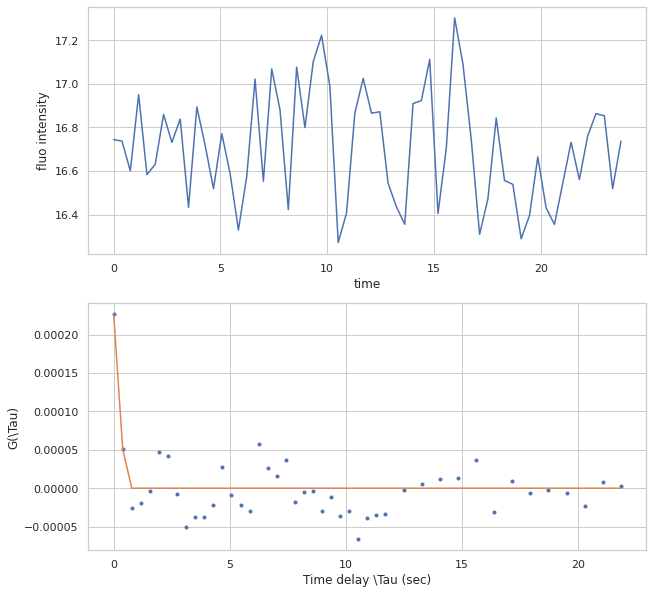

In [56]:
# Analyse one track
# Choose your track id
id_= np.unique(datas.TRACK_ID)[0]
id_ = 18
print(id_)

x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values/2**16*100
fig, ax = plt.subplots(2,1)
ax[0].plot(x,y)
ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")

mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
if (mm%2)==0: 
    autocor = multipletau.autocorrelate(y,
                                    m=mm,
                                    deltat=DELTA_T, 
                                    normalize=True)
else: 
    autocor = multipletau.autocorrelate(y,
                                    m=mm+1,
                                    deltat=DELTA_T,
                                    normalize=True)



popt, pcov = optimize.curve_fit(func_, 
                            autocor.flatten()[0::2],
                            autocor.flatten()[1::2], 
                            method='lm' )


ax[1].plot(autocor.flatten()[0::2], autocor.flatten()[1::2], '.')
ax[1].plot(autocor.flatten()[0::2], func_(autocor.flatten()[0::2], *popt) )
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")

fig.set_size_inches((10,10))

# plot all track that was keep in result table

In [58]:
columns = ['file_name', 'track_id','len_track', 'elongation_time', 'init_translation_rate']
result = pd.DataFrame(columns=columns, dtype=float)
elongation_time=[]
translation_rate=[]

datas = pd.read_csv(f)
datas.drop(index=[0,1,2], inplace=True)
datas['FRAME'] = pd.to_numeric(datas["FRAME"])
datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])



for id_ in np.unique(datas['TRACK_ID']):

    x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
    y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values

    mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
    if (mm%2)==0: 
        autocor = multipletau.autocorrelate(y,
                                        m=mm,
                                        deltat=DELTA_T, 
                                        normalize=True)
    else: 
        autocor = multipletau.autocorrelate(y,
                                        m=mm+1,
                                        deltat=DELTA_T,
                                        normalize=True)



    popt, pcov = optimize.curve_fit(func_, 
                                autocor.flatten()[0::2],
                                autocor.flatten()[1::2], 
                                method='lm' )
    if popt[0]>0:
        d = pd.DataFrame.from_dict({'file_name':f.split('/')[-2],
                                    'track_id':id_,
                                    'len_track': len(x),
                                    'elongation_time':popt[0],
                                    'init_translation_rate':popt[1]},
                                   orient='index').T
        result = pd.concat([result, d], ignore_index=True)

# result.drop(result[result["len_track"]<100].index, inplace=True)

In [59]:
result

,file_name,track_id,len_track,elongation_time,init_translation_rate
0,120822 ScFv msGFP2 x Snail Core 32X Suntag 24 ...,6,52,0.875602,9200.893913
1,120822 ScFv msGFP2 x Snail Core 32X Suntag 24 ...,7,61,0.968555,6129.705804
2,120822 ScFv msGFP2 x Snail Core 32X Suntag 24 ...,12,61,5.849998,1404.099809
3,120822 ScFv msGFP2 x Snail Core 32X Suntag 24 ...,14,55,0.512436,18915.419578
4,120822 ScFv msGFP2 x Snail Core 32X Suntag 24 ...,18,61,0.502088,8804.044461
5,120822 ScFv msGFP2 x Snail Core 32X Suntag 24 ...,19,35,0.389819,30084.704622
6,120822 ScFv msGFP2 x Snail Core 32X Suntag 24 ...,24,61,0.424883,19920.426475
7,120822 ScFv msGFP2 x Snail Core 32X Suntag 24 ...,28,50,0.561975,18180.277206
8,120822 ScFv msGFP2 x Snail Core 32X Suntag 24 ...,32,62,0.781567,14916.467101
9,120822 ScFv msGFP2 x Snail Core 32X Suntag 24 ...,33,58,0.420357,30293.123299


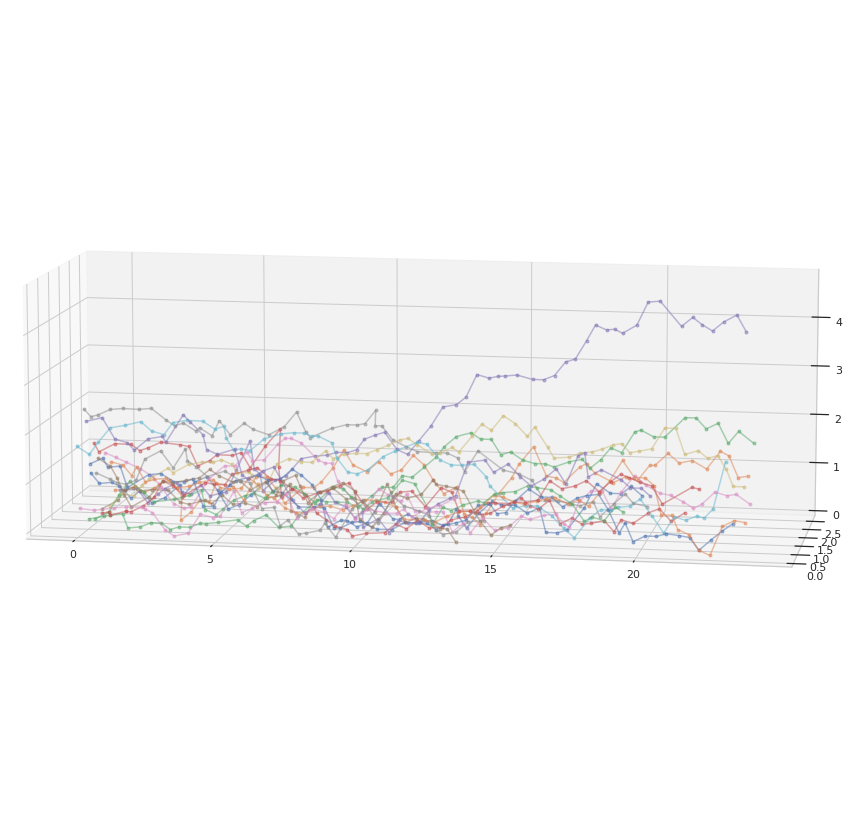

In [60]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')

# ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.5, 0.5, 1]))
ax.set_box_aspect(aspect = (3,1,1))


for id_ in np.unique(result['track_id'].to_numpy()):
    x = (datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].to_numpy()
         - np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].to_numpy()))
    y = (datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_X'].to_numpy()
         - np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_X'].to_numpy()))
    z = (datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_Y'].to_numpy()
         - np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_Y'].to_numpy()))
    
    ax.plot(x, 
            y, 
            z, 
            '.-',
            alpha = 0.5
            )


fig.set_size_inches((15, 15))

ax.view_init(elev=10., azim=-80)

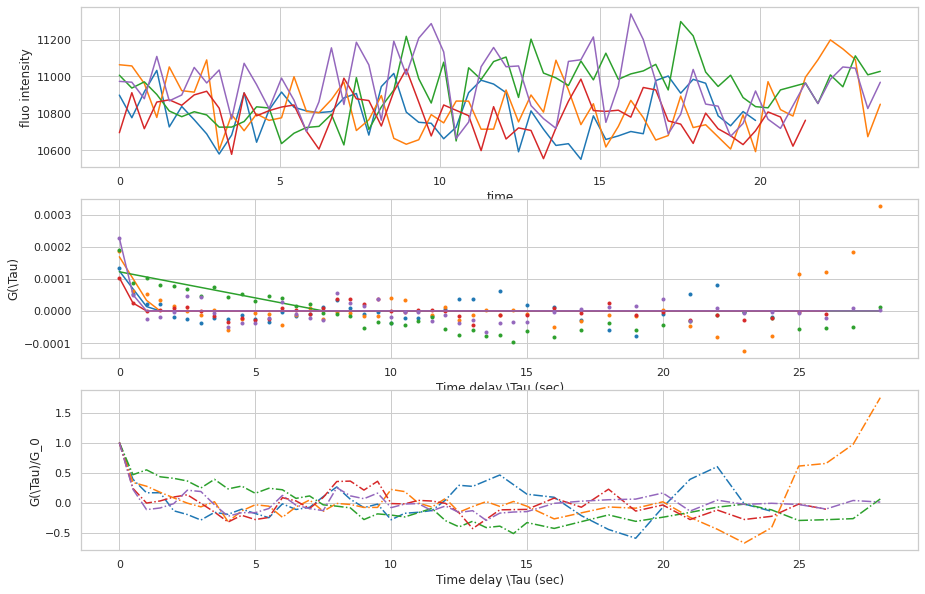

In [62]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(3,1)

colors = list(mcolors.TABLEAU_COLORS.keys())

i=0
for id_ in np.unique(result['track_id'])[:5]:

    x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
    y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values
    
    ax[0].plot(x, y, color=colors[i])


    mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
    if (mm%2)==0: 
        autocor = multipletau.autocorrelate(y,
                                        m=mm,
                                        deltat=0.5, 
                                        normalize=True)
    else: 
        autocor = multipletau.autocorrelate(y,
                                        m=mm+1,
                                        deltat=0.5,
                                        normalize=True)



    popt, pcov = optimize.curve_fit(func_, 
                                autocor.flatten()[0::2],
                                autocor.flatten()[1::2], 
                                method='lm' )


    ax[1].plot(autocor.flatten()[0::2], autocor.flatten()[1::2], '.', color=colors[i])
    ax[1].plot(autocor.flatten()[0::2], func_(autocor.flatten()[0::2], *popt), color=colors[i] )
    
    ax[2].plot(autocor.flatten()[0::2], autocor.flatten()[1::2]/autocor.flatten()[1], '-.', color=colors[i])
    
    
    if i == 7:
        i=0
    else:
        i+=1

ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")

ax[2].set_xlabel("Time delay \Tau (sec)")
ax[2].set_ylabel("G(\Tau)/G_0")

fig.set_size_inches((15,10))

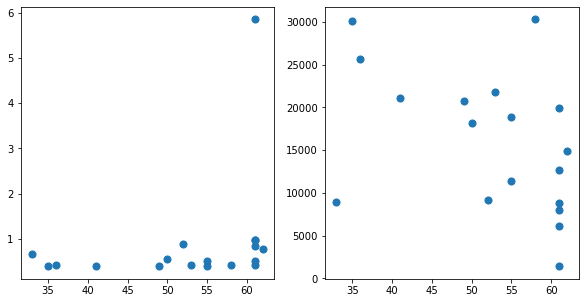

In [12]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(result['len_track'], result['elongation_time'], s=50)
ax[1].scatter(result['len_track'], result['init_translation_rate'], s=50)
fig.set_size_inches((10,5))

# Multiple file analysis

In [11]:
path = "/mnt/sda1/Sophie/3-KineticAnalysisData/2-Datas/SnailSuntag/"
files = [
    "1-sna-suntag-fast-imaging/220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t3_Airyscan Processing-20",
    "1-sna-suntag-fast-imaging/220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t4_Airyscan Processing-20",
    "1-sna-suntag-fast-imaging/220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t5_Airyscan Processing-20",
#     "2-120822-scfv-msgfp2-x-snail-core-32x-suntag-24-xms2-q670-cy3-flap-y-dapi-e3/120822 ScFv msGFP2 x Snail Core 32X Suntag 24 XMS2 Q670 Cy3 Flap Y DAPI E3 t2 z8_Airyscan Processing-01",
    "3-100822-scfv-msgfp2-x-snail-shadow-32x-suntag-24x-ms2-e2-zoom-8/100822 scFv msGFP2 x Snail Shadow 32X Suntag 24X MS2 E2 zoom 8_Airyscan Processing",
#     "3-100822-scfv-msgfp2-x-snail-shadow-32x-suntag-24x-ms2-e2-zoom-8/scFv msGFP2 x Snail Shadow 32X Sunatg 24X MS2 E1 zoom 8_Airyscan Processing-03"
        ]


In [12]:
columns = ['file_name', 'track_id','len_track', 'elongation_time', 'init_translation_rate']
result = pd.DataFrame(columns=columns, dtype=float)
elongation_time=[]
translation_rate=[]
for f in files:
    f = path+f+"/track_spot_table.csv"
    datas = pd.read_csv(f)
    datas.drop(index=[0,1,2], inplace=True)
    datas['FRAME'] = pd.to_numeric(datas["FRAME"])
    datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
    datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
    datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
    datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
    datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])
    


    for id_ in np.unique(datas['TRACK_ID']):
        
        x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
        y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values

        mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
        if (mm%2)==0: 
            autocor = multipletau.autocorrelate(y,
                                            m=mm,
                                            deltat=DELTA_T, 
                                            normalize=True)
        else: 
            autocor = multipletau.autocorrelate(y,
                                            m=mm+1,
                                            deltat=DELTA_T,
                                            normalize=True)



        popt, pcov = optimize.curve_fit(func_, 
                                    autocor.flatten()[0::2],
                                    autocor.flatten()[1::2], 
                                    method='lm' )
        if popt[0]>0:
            d = pd.DataFrame.from_dict({'file_name':f.split('/')[-2],
                                        'track_id':id_,
                                        'len_track': len(x),
                                        'elongation_time':popt[0],
                                        'init_translation_rate':popt[1]},
                                       orient='index').T
            result = pd.concat([result, d], ignore_index=True)

# result.drop(result[result["len_track"]<100].index, inplace=True)

In [13]:
result

,file_name,track_id,len_track,elongation_time,init_translation_rate
0,220822 scFv msGFP2 x Snail Core 32X Suntag 24X...,2,81,0.958432,29.47588
1,220822 scFv msGFP2 x Snail Core 32X Suntag 24X...,5,65,9.666031,1.983251
2,220822 scFv msGFP2 x Snail Core 32X Suntag 24X...,11,57,1.805528,9.621011
3,220822 scFv msGFP2 x Snail Core 32X Suntag 24X...,12,57,0.477914,43.827794
4,220822 scFv msGFP2 x Snail Core 32X Suntag 24X...,14,56,0.983667,13.593699
5,220822 scFv msGFP2 x Snail Core 32X Suntag 24X...,20,43,0.979636,12.887503
6,220822 scFv msGFP2 x Snail Core 32X Suntag 24X...,22,52,1.035337,37.99877
7,220822 scFv msGFP2 x Snail Core 32X Suntag 24X...,23,43,2.994222,2.464856
8,220822 scFv msGFP2 x Snail Core 32X Suntag 24X...,30,45,5.430587,2.950176
9,220822 scFv msGFP2 x Snail Core 32X Suntag 24X...,33,39,0.66781,24.030424


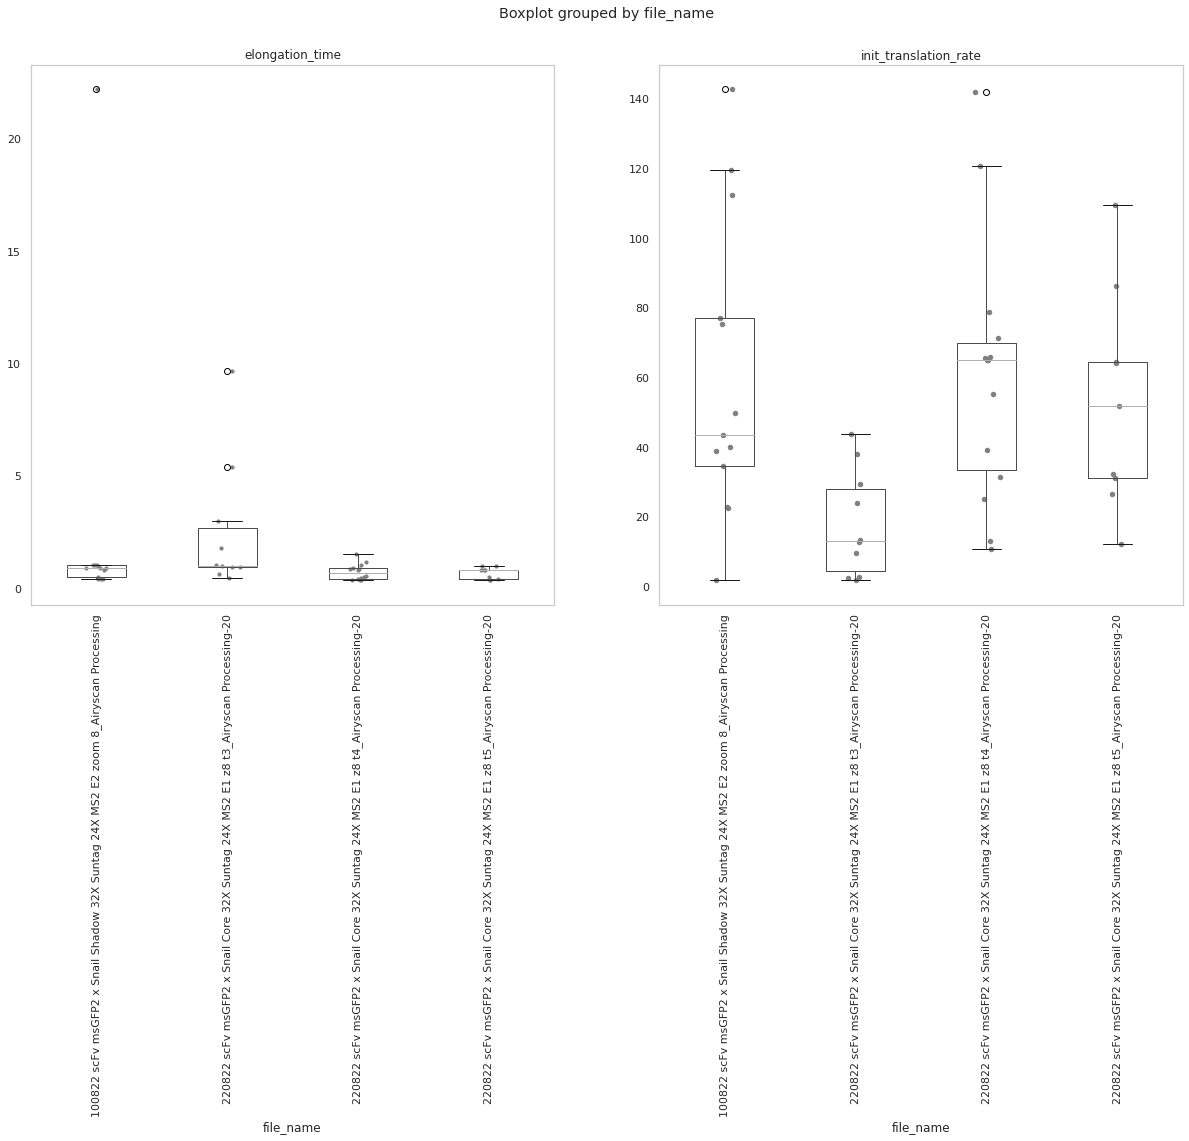

In [44]:
# result['elongation_time'] = pd.to_numeric(result['elongation_time'])
fig, ax = plt.subplots(1,2)
result.boxplot(['elongation_time'] , 
               by='file_name', 
               grid=False, 
               ax = ax[0],
               rot=90, 
              )

result.boxplot([ 'init_translation_rate'] , 
               by='file_name', 
               grid=False, 
               ax = ax[1],
               rot=90
               )

group = 'file_name'
column = 'elongation_time'
grouped = result.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., ngroup)
for x, val, clevel in zip(xs, vals, clevels):
    ax[0].scatter(x, val, c='grey', alpha=1, s=10)
    
    
group = 'file_name'
column = 'init_translation_rate'
grouped = result.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., ngroup)
for x, val, clevel in zip(xs, vals, clevels):
    ax[1].scatter(x, val, c='grey', alpha=1, s=20)
    
# ax[1].set_ylim(0,250)
fig.set_size_inches((20,10))

In [25]:
result.groupby(by='file_name').mean()

,track_id,len_track,elongation_time,init_translation_rate
file_name,,,,
100822 scFv msGFP2 x Snail Shadow 32X Suntag 24X MS2 E2 zoom 8_Airyscan Processing,71.230769,88.461538,2.440606,60.208571
120822 ScFv msGFP2 x Snail Core 32X Suntag 24 XMS2 Q670 Cy3 Flap Y DAPI E3 t2 z8_Airyscan Processing-01,48.500000,52.500000,0.877175,16006.863042
220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t3_Airyscan Processing-20,17.200000,53.800000,2.499916,17.883336
220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t4_Airyscan Processing-20,31.357143,44.357143,0.739889,60.737953
220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t5_Airyscan Processing-20,174.444444,56.222222,0.686883,53.273280
scFv msGFP2 x Snail Shadow 32X Sunatg 24X MS2 E1 zoom 8_Airyscan Processing-03,3.000000,20.000000,1.469481,1737.727016


In [ ]:
result.boxplot(['elongation_time'] , 
               by='file_name', 
               grid=False, 
               ax = ax[0],
               rot=90, 
              )

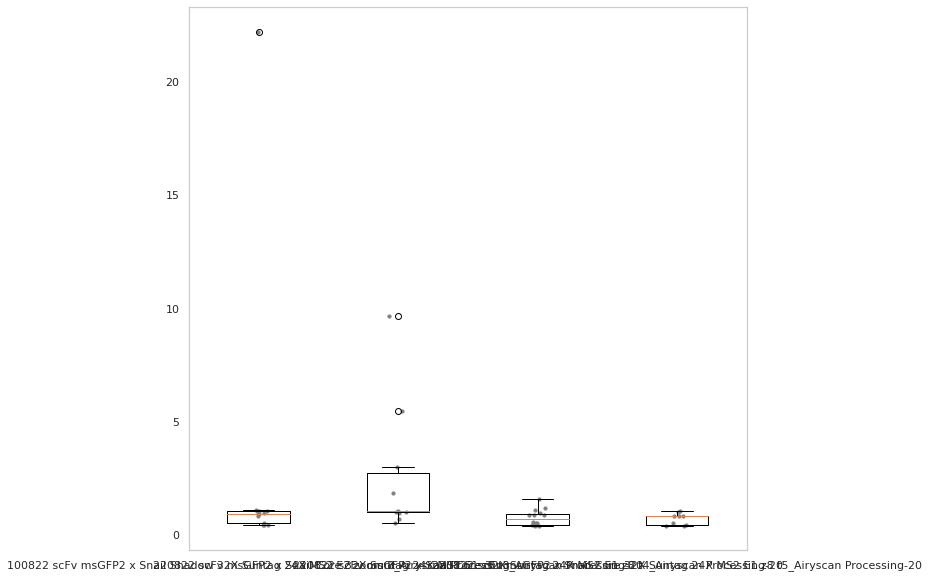

In [37]:
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# initialize dataframe
# n = 200
# ngroup = 3
# df = pd.DataFrame({'data': np.random.rand(n), 'group': map(np.floor, np.random.rand(n) * ngroup)})
fig, ax = plt.subplots()

group = 'file_name'
column = 'elongation_time'
grouped = result.groupby(group)

names, vals, xs = [], [] ,[]

for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

ax.boxplot(vals, labels=names, )
ngroup = len(vals)



for x, val, clevel in zip(xs, vals, clevels):
    ax.scatter(x, val, c='grey', alpha=1, s=10)
    
ax.grid(False)
fig.set_size_inches((10,10))